In [1]:
import numpy as np
from IPython.display import Image

Before we start programming, let's stop for a moment and prepare a basic roadmap. Our goal is to create a program capable of creating a densely connected neural network with the specified architecture (number and size of layers and appropriate activation function). An example of such a network is presented in Figure 1. Above all, we must be able to our network and make predictions using it.

![Roadmap](./supporting_visualizations/blueprint.gif)

<b>Figure 2.</b> Neural network blueprint

Diagram above shows what operations will have to be performed during the training of our neural network. It also shows how many parameters we will have to update and read at different stages of a single iteration. Building the right data structure and skillfully managing its state is the most difficult part of our task.

## Network architecture

![Network architecture](./supporting_visualizations/nn_architecture.png)

<b>Figure 1.</b> Example of dense neural network architecture

In [2]:
NN_ARCHITECTURE = [
    {"input_dim": 2, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 1, "activation": "sigmoid"},
]

![Parameters sizes](./supporting_visualizations/params_sizes.png)

<b>Figure 3.</b> Dimensions of weight matrix W and bias vector b for layer l.

Let's start with by initiating weight matrix W and bias vector b for each layer. In Figure 3 I have prepared a small cheatsheet, which will help us to asign the appropriate dimensions for these coefficients. Superscript [l] denotes the index of the current layer (counted from 1). I assumed that the information describing the NN architecture will be delivered to our program in the form of list. Each item in the list is a dictionary describing the basic parameters of a single network layer: input_dim - the size of the signal vector supplied as an input for the layer, output_dim - the size of the activation vector obtained at the output of the layer and activation - the activation function to be used inside the layer.

In [3]:
def init_layers(nn_architecture, seed = 99):
    # random seed initiation
    np.random.seed(seed)
    # number of layers in our neural network
    number_of_layers = len(nn_architecture)
    # parameters storage initiation
    params_values = {}
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        
        # extracting the number of units in layers
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        # initiating the values of the W matrix
        # and vector b for subsequent layers
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1
        
    return params_values

In [4]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

In [5]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    # calculation of the input value for the activation function
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    # selection of activation function
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
        
    # return of calculated activation A and the intermediate Z matrix
    return activation_func(Z_curr), Z_curr

<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-5-d3e2bf7974c7>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if activation is "relu":
<ipython-input-5-d3e2bf7974c7>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif activation is "sigmoid":


In [6]:
def full_forward_propagation(X, params_values, nn_architecture):
    # creating a temporary memory to store the information needed for a backward step
    memory = {}
    # X vector is the activation for layer 0 
    A_curr = X
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        # transfer the activation from the previous iteration
        A_prev = A_curr
        
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        # extraction of W for the current layer
        W_curr = params_values["W" + str(layer_idx)]
        # extraction of b for the current layer
        b_curr = params_values["b" + str(layer_idx)]
        # calculation of activation for the current layer
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        # saving calculated values in the memory
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    # return of prediction vector and a dictionary containing intermediate values
    return A_curr, memory

In order to monitor our progress and make sure that we are moving in desired direction, we should routinely calculate the value of the loss function. "Generally speaking, the loss function is designed to show how far we are from the 'ideal' solution." It is selected according to the problem we plan to solve, and frameworks such as Keras have many options to choose from. Because I am planning to test our NN for the classification of points between two classes, I decided to use binary crossentropy, which is defined by the following formulas. In order to give us more information on how our neural network is coping with the task, I have also decided to implement a function that will calculate accuracy for us.

![Cost Function](./supporting_visualizations/cost_function.gif)

In [7]:
def get_cost_value(Y_hat, Y):
    # number of examples
    m = Y_hat.shape[1]
    # calculation of the cost according to the formula
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost)

In [8]:
# an auxiliary function that converts probability into class
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

Sadly, backward propagation is regarded by many inexperienced deep learning enthusiasts as algorithm that is intimidating and difficult to understand. The combination of differential calculus and linear algebra very often deters people who do not have a solid mathematical training. 

Often people confuse backward propaganda with gradient descent, but in fact these are two separate matters. The purpose of the first one is to calculate the gradient effectively, whereas the second one is to use the calculated gradient to optimize. In NN, we calculate the gradient of the cost function (discussed earlier) in respect to parameters, but backpropagation can be used to calculate derivatives of any function. The essence of this algorithm is the recursive use of a chain rule known from differential calculus - calculate a derivative of functions created by assembling other functions, whose derivatives we already know. This process - for one network layer - is described by the following formulas. Unfortunately, due to the fact that this article focuses mainly on practical implementation, I'll omit the derivation. Looking at the formulas, it becomes obvious why we decided to remember the values of the A and Z matrices for intermediate layers in a forward step.

$$\boldsymbol{dW}^{[l]} = \frac{\partial L }{\partial \boldsymbol{W}^{[l]}} = \frac{1}{m} \boldsymbol{dZ}^{[l]} \boldsymbol{A}^{[l-1] T}$$

$$\boldsymbol{db}^{[l]} = \frac{\partial L }{\partial \boldsymbol{b}^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} \boldsymbol{dZ}^{[l](i)}$$

$$\boldsymbol{dA}^{[l-1]} = \frac{\partial L }{\partial \boldsymbol{A}^{[l-1]}} = \boldsymbol{W}^{[l] T} \boldsymbol{dZ}^{[l]}$$

$$\boldsymbol{dZ}^{[l]} = \boldsymbol{dA}^{[l]} * g'(\boldsymbol{Z}^{[l]})$$


In [9]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    # number of examples
    m = A_prev.shape[1]
    
    # selection of activation function
    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')
    
    # calculation of the activation function derivative
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    
    # derivative of the matrix W
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    # derivative of the vector b
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    # derivative of the matrix A_prev
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
<ipython-input-9-0a7b214a3e1f>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if activation is "relu":
<ipython-input-9-0a7b214a3e1f>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif activation is "sigmoid":


In [10]:
def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    
    # number of examples
    m = Y.shape[1]
    # a hack ensuring the same shape of the prediction vector and labels vector
    Y = Y.reshape(Y_hat.shape)
    
    # initiation of gradient descent algorithm
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        # we number network layers from 1
        layer_idx_curr = layer_idx_prev + 1
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

In [15]:
def update(params_values, grads_values, nn_architecture, learning_rate):

    # iteration over network layers
    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values;

def train(X, Y, nn_architecture, epochs, learning_rate, verbose=False, callback=None):
    # initiation of neural net parameters
    params_values = init_layers(nn_architecture, 2)
    # initiation of lists storing the history 
    # of metrics calculated during the learning process 
    cost_history = []
    accuracy_history = []
    
    # performing calculations for subsequent iterations
    for i in range(epochs):
        # step forward
        Y_hat, cashe = full_forward_propagation(X, params_values, nn_architecture)
        
        # calculating metrics and saving them in history
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)
        
        # step backward - calculating gradient
        grads_values = full_backward_propagation(Y_hat, Y, cashe, params_values, nn_architecture)
        # updating model state
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
        if(i % 50 == 0):
            if(verbose):
                print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            if(callback is not None):
                callback(i, params_values)
            
    return params_values

In [16]:
import os
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid")

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras import regularizers

from sklearn.metrics import accuracy_score

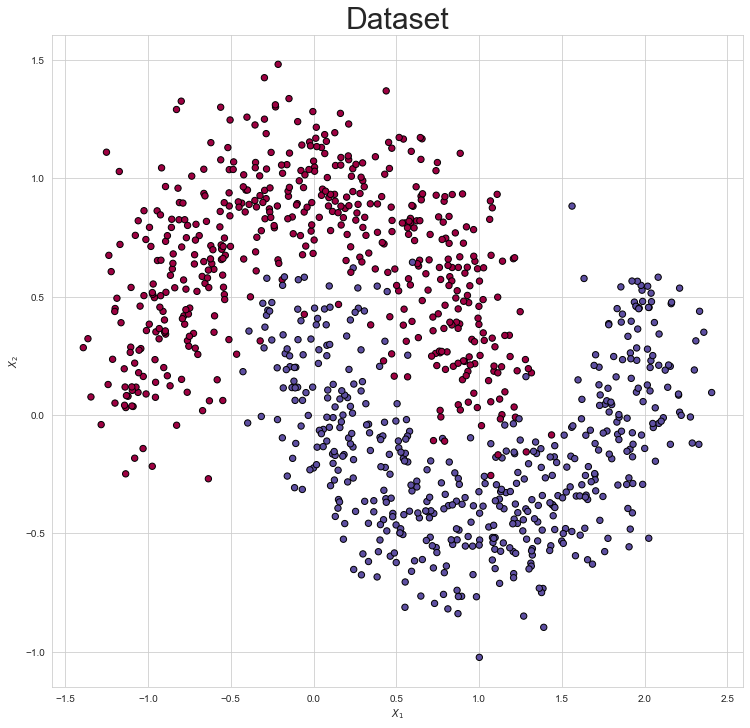

In [17]:
# number of samples in the data set
N_SAMPLES = 1000
# ratio between training and test sets
TEST_SIZE = 0.1
X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)
X.shape
y.shape

# the function making up the graph of a dataset
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()
        
make_plot(X, y, "Dataset")

In [18]:
# Training
params_values = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 100000, 0.001,verbose=True)
#print(params_values)

Iteration: 00000 - cost: 0.68341 - accuracy: 0.50444
Iteration: 00050 - cost: 0.68224 - accuracy: 0.50444
Iteration: 00100 - cost: 0.68106 - accuracy: 0.50444
Iteration: 00150 - cost: 0.67989 - accuracy: 0.50444
Iteration: 00200 - cost: 0.67871 - accuracy: 0.50444
Iteration: 00250 - cost: 0.67753 - accuracy: 0.50444
Iteration: 00300 - cost: 0.67635 - accuracy: 0.50778
Iteration: 00350 - cost: 0.67517 - accuracy: 0.51333
Iteration: 00400 - cost: 0.67399 - accuracy: 0.52111
Iteration: 00450 - cost: 0.67281 - accuracy: 0.53111
Iteration: 00500 - cost: 0.67162 - accuracy: 0.55333
Iteration: 00550 - cost: 0.67043 - accuracy: 0.58111
Iteration: 00600 - cost: 0.66923 - accuracy: 0.60333
Iteration: 00650 - cost: 0.66805 - accuracy: 0.62111
Iteration: 00700 - cost: 0.66686 - accuracy: 0.64667
Iteration: 00750 - cost: 0.66567 - accuracy: 0.67222
Iteration: 00800 - cost: 0.66447 - accuracy: 0.69111
Iteration: 00850 - cost: 0.66328 - accuracy: 0.70667
Iteration: 00900 - cost: 0.66209 - accuracy: 0

Iteration: 08000 - cost: 0.41645 - accuracy: 0.83111
Iteration: 08050 - cost: 0.41505 - accuracy: 0.83222
Iteration: 08100 - cost: 0.41366 - accuracy: 0.83333
Iteration: 08150 - cost: 0.41229 - accuracy: 0.83333
Iteration: 08200 - cost: 0.41094 - accuracy: 0.83333
Iteration: 08250 - cost: 0.40960 - accuracy: 0.83333
Iteration: 08300 - cost: 0.40827 - accuracy: 0.83333
Iteration: 08350 - cost: 0.40696 - accuracy: 0.83333
Iteration: 08400 - cost: 0.40566 - accuracy: 0.83333
Iteration: 08450 - cost: 0.40438 - accuracy: 0.83333
Iteration: 08500 - cost: 0.40311 - accuracy: 0.83444
Iteration: 08550 - cost: 0.40186 - accuracy: 0.83444
Iteration: 08600 - cost: 0.40062 - accuracy: 0.83444
Iteration: 08650 - cost: 0.39939 - accuracy: 0.83444
Iteration: 08700 - cost: 0.39818 - accuracy: 0.83444
Iteration: 08750 - cost: 0.39698 - accuracy: 0.83444
Iteration: 08800 - cost: 0.39580 - accuracy: 0.83667
Iteration: 08850 - cost: 0.39463 - accuracy: 0.83778
Iteration: 08900 - cost: 0.39347 - accuracy: 0

Iteration: 15750 - cost: 0.31178 - accuracy: 0.86222
Iteration: 15800 - cost: 0.31149 - accuracy: 0.86222
Iteration: 15850 - cost: 0.31120 - accuracy: 0.86333
Iteration: 15900 - cost: 0.31092 - accuracy: 0.86333
Iteration: 15950 - cost: 0.31063 - accuracy: 0.86333
Iteration: 16000 - cost: 0.31035 - accuracy: 0.86333
Iteration: 16050 - cost: 0.31007 - accuracy: 0.86333
Iteration: 16100 - cost: 0.30979 - accuracy: 0.86333
Iteration: 16150 - cost: 0.30952 - accuracy: 0.86333
Iteration: 16200 - cost: 0.30925 - accuracy: 0.86333
Iteration: 16250 - cost: 0.30898 - accuracy: 0.86333
Iteration: 16300 - cost: 0.30871 - accuracy: 0.86333
Iteration: 16350 - cost: 0.30844 - accuracy: 0.86444
Iteration: 16400 - cost: 0.30818 - accuracy: 0.86444
Iteration: 16450 - cost: 0.30792 - accuracy: 0.86444
Iteration: 16500 - cost: 0.30766 - accuracy: 0.86556
Iteration: 16550 - cost: 0.30740 - accuracy: 0.86667
Iteration: 16600 - cost: 0.30714 - accuracy: 0.86667
Iteration: 16650 - cost: 0.30689 - accuracy: 0

Iteration: 23550 - cost: 0.28547 - accuracy: 0.87556
Iteration: 23600 - cost: 0.28538 - accuracy: 0.87556
Iteration: 23650 - cost: 0.28529 - accuracy: 0.87556
Iteration: 23700 - cost: 0.28521 - accuracy: 0.87556
Iteration: 23750 - cost: 0.28512 - accuracy: 0.87667
Iteration: 23800 - cost: 0.28503 - accuracy: 0.87667
Iteration: 23850 - cost: 0.28495 - accuracy: 0.87667
Iteration: 23900 - cost: 0.28486 - accuracy: 0.87778
Iteration: 23950 - cost: 0.28478 - accuracy: 0.87778
Iteration: 24000 - cost: 0.28469 - accuracy: 0.87778
Iteration: 24050 - cost: 0.28461 - accuracy: 0.87778
Iteration: 24100 - cost: 0.28453 - accuracy: 0.87778
Iteration: 24150 - cost: 0.28445 - accuracy: 0.87778
Iteration: 24200 - cost: 0.28436 - accuracy: 0.87778
Iteration: 24250 - cost: 0.28428 - accuracy: 0.87778
Iteration: 24300 - cost: 0.28420 - accuracy: 0.87889
Iteration: 24350 - cost: 0.28412 - accuracy: 0.87889
Iteration: 24400 - cost: 0.28404 - accuracy: 0.87889
Iteration: 24450 - cost: 0.28397 - accuracy: 0

Iteration: 31450 - cost: 0.27679 - accuracy: 0.87778
Iteration: 31500 - cost: 0.27675 - accuracy: 0.87778
Iteration: 31550 - cost: 0.27672 - accuracy: 0.87778
Iteration: 31600 - cost: 0.27669 - accuracy: 0.87778
Iteration: 31650 - cost: 0.27666 - accuracy: 0.87778
Iteration: 31700 - cost: 0.27663 - accuracy: 0.87778
Iteration: 31750 - cost: 0.27660 - accuracy: 0.87778
Iteration: 31800 - cost: 0.27657 - accuracy: 0.87778
Iteration: 31850 - cost: 0.27654 - accuracy: 0.87778
Iteration: 31900 - cost: 0.27651 - accuracy: 0.87778
Iteration: 31950 - cost: 0.27647 - accuracy: 0.87778
Iteration: 32000 - cost: 0.27645 - accuracy: 0.87778
Iteration: 32050 - cost: 0.27642 - accuracy: 0.87778
Iteration: 32100 - cost: 0.27639 - accuracy: 0.87778
Iteration: 32150 - cost: 0.27636 - accuracy: 0.87778
Iteration: 32200 - cost: 0.27633 - accuracy: 0.87778
Iteration: 32250 - cost: 0.27630 - accuracy: 0.87778
Iteration: 32300 - cost: 0.27627 - accuracy: 0.87778
Iteration: 32350 - cost: 0.27624 - accuracy: 0

Iteration: 39300 - cost: 0.27337 - accuracy: 0.88111
Iteration: 39350 - cost: 0.27335 - accuracy: 0.88111
Iteration: 39400 - cost: 0.27334 - accuracy: 0.88111
Iteration: 39450 - cost: 0.27332 - accuracy: 0.88111
Iteration: 39500 - cost: 0.27331 - accuracy: 0.88111
Iteration: 39550 - cost: 0.27329 - accuracy: 0.88111
Iteration: 39600 - cost: 0.27328 - accuracy: 0.88111
Iteration: 39650 - cost: 0.27326 - accuracy: 0.88111
Iteration: 39700 - cost: 0.27325 - accuracy: 0.88111
Iteration: 39750 - cost: 0.27323 - accuracy: 0.88111
Iteration: 39800 - cost: 0.27322 - accuracy: 0.88111
Iteration: 39850 - cost: 0.27320 - accuracy: 0.88111
Iteration: 39900 - cost: 0.27319 - accuracy: 0.88111
Iteration: 39950 - cost: 0.27317 - accuracy: 0.88111
Iteration: 40000 - cost: 0.27316 - accuracy: 0.88111
Iteration: 40050 - cost: 0.27315 - accuracy: 0.88111
Iteration: 40100 - cost: 0.27313 - accuracy: 0.88111
Iteration: 40150 - cost: 0.27312 - accuracy: 0.88111
Iteration: 40200 - cost: 0.27310 - accuracy: 0

Iteration: 47050 - cost: 0.27146 - accuracy: 0.88111
Iteration: 47100 - cost: 0.27145 - accuracy: 0.88111
Iteration: 47150 - cost: 0.27144 - accuracy: 0.88111
Iteration: 47200 - cost: 0.27143 - accuracy: 0.88111
Iteration: 47250 - cost: 0.27142 - accuracy: 0.88111
Iteration: 47300 - cost: 0.27141 - accuracy: 0.88111
Iteration: 47350 - cost: 0.27140 - accuracy: 0.88111
Iteration: 47400 - cost: 0.27139 - accuracy: 0.88111
Iteration: 47450 - cost: 0.27138 - accuracy: 0.88000
Iteration: 47500 - cost: 0.27137 - accuracy: 0.88000
Iteration: 47550 - cost: 0.27136 - accuracy: 0.88000
Iteration: 47600 - cost: 0.27135 - accuracy: 0.88000
Iteration: 47650 - cost: 0.27134 - accuracy: 0.88000
Iteration: 47700 - cost: 0.27132 - accuracy: 0.88000
Iteration: 47750 - cost: 0.27131 - accuracy: 0.88000
Iteration: 47800 - cost: 0.27130 - accuracy: 0.88000
Iteration: 47850 - cost: 0.27129 - accuracy: 0.88000
Iteration: 47900 - cost: 0.27128 - accuracy: 0.88000
Iteration: 47950 - cost: 0.27127 - accuracy: 0

Iteration: 55150 - cost: 0.26987 - accuracy: 0.88111
Iteration: 55200 - cost: 0.26986 - accuracy: 0.88111
Iteration: 55250 - cost: 0.26985 - accuracy: 0.88111
Iteration: 55300 - cost: 0.26984 - accuracy: 0.88111
Iteration: 55350 - cost: 0.26983 - accuracy: 0.88111
Iteration: 55400 - cost: 0.26982 - accuracy: 0.88111
Iteration: 55450 - cost: 0.26981 - accuracy: 0.88111
Iteration: 55500 - cost: 0.26980 - accuracy: 0.88111
Iteration: 55550 - cost: 0.26979 - accuracy: 0.88111
Iteration: 55600 - cost: 0.26978 - accuracy: 0.88111
Iteration: 55650 - cost: 0.26977 - accuracy: 0.88111
Iteration: 55700 - cost: 0.26976 - accuracy: 0.88111
Iteration: 55750 - cost: 0.26975 - accuracy: 0.88111
Iteration: 55800 - cost: 0.26975 - accuracy: 0.88111
Iteration: 55850 - cost: 0.26974 - accuracy: 0.88111
Iteration: 55900 - cost: 0.26973 - accuracy: 0.88111
Iteration: 55950 - cost: 0.26972 - accuracy: 0.88111
Iteration: 56000 - cost: 0.26971 - accuracy: 0.88111
Iteration: 56050 - cost: 0.26970 - accuracy: 0

Iteration: 63000 - cost: 0.26836 - accuracy: 0.88222
Iteration: 63050 - cost: 0.26835 - accuracy: 0.88222
Iteration: 63100 - cost: 0.26834 - accuracy: 0.88222
Iteration: 63150 - cost: 0.26833 - accuracy: 0.88222
Iteration: 63200 - cost: 0.26832 - accuracy: 0.88222
Iteration: 63250 - cost: 0.26831 - accuracy: 0.88222
Iteration: 63300 - cost: 0.26830 - accuracy: 0.88222
Iteration: 63350 - cost: 0.26829 - accuracy: 0.88222
Iteration: 63400 - cost: 0.26828 - accuracy: 0.88222
Iteration: 63450 - cost: 0.26827 - accuracy: 0.88222
Iteration: 63500 - cost: 0.26826 - accuracy: 0.88222
Iteration: 63550 - cost: 0.26825 - accuracy: 0.88222
Iteration: 63600 - cost: 0.26824 - accuracy: 0.88222
Iteration: 63650 - cost: 0.26823 - accuracy: 0.88222
Iteration: 63700 - cost: 0.26822 - accuracy: 0.88222
Iteration: 63750 - cost: 0.26821 - accuracy: 0.88222
Iteration: 63800 - cost: 0.26820 - accuracy: 0.88222
Iteration: 63850 - cost: 0.26819 - accuracy: 0.88222
Iteration: 63900 - cost: 0.26818 - accuracy: 0

Iteration: 70900 - cost: 0.26676 - accuracy: 0.88222
Iteration: 70950 - cost: 0.26675 - accuracy: 0.88222
Iteration: 71000 - cost: 0.26674 - accuracy: 0.88222
Iteration: 71050 - cost: 0.26673 - accuracy: 0.88222
Iteration: 71100 - cost: 0.26672 - accuracy: 0.88222
Iteration: 71150 - cost: 0.26671 - accuracy: 0.88222
Iteration: 71200 - cost: 0.26670 - accuracy: 0.88222
Iteration: 71250 - cost: 0.26668 - accuracy: 0.88222
Iteration: 71300 - cost: 0.26667 - accuracy: 0.88222
Iteration: 71350 - cost: 0.26666 - accuracy: 0.88222
Iteration: 71400 - cost: 0.26665 - accuracy: 0.88222
Iteration: 71450 - cost: 0.26664 - accuracy: 0.88222
Iteration: 71500 - cost: 0.26663 - accuracy: 0.88222
Iteration: 71550 - cost: 0.26662 - accuracy: 0.88222
Iteration: 71600 - cost: 0.26661 - accuracy: 0.88222
Iteration: 71650 - cost: 0.26660 - accuracy: 0.88222
Iteration: 71700 - cost: 0.26659 - accuracy: 0.88222
Iteration: 71750 - cost: 0.26658 - accuracy: 0.88222
Iteration: 71800 - cost: 0.26657 - accuracy: 0

Iteration: 78800 - cost: 0.26505 - accuracy: 0.88111
Iteration: 78850 - cost: 0.26504 - accuracy: 0.88111
Iteration: 78900 - cost: 0.26503 - accuracy: 0.88111
Iteration: 78950 - cost: 0.26501 - accuracy: 0.88111
Iteration: 79000 - cost: 0.26500 - accuracy: 0.88111
Iteration: 79050 - cost: 0.26499 - accuracy: 0.88111
Iteration: 79100 - cost: 0.26498 - accuracy: 0.88111
Iteration: 79150 - cost: 0.26497 - accuracy: 0.88111
Iteration: 79200 - cost: 0.26496 - accuracy: 0.88111
Iteration: 79250 - cost: 0.26495 - accuracy: 0.88111
Iteration: 79300 - cost: 0.26494 - accuracy: 0.88111
Iteration: 79350 - cost: 0.26492 - accuracy: 0.88111
Iteration: 79400 - cost: 0.26491 - accuracy: 0.88111
Iteration: 79450 - cost: 0.26490 - accuracy: 0.88111
Iteration: 79500 - cost: 0.26489 - accuracy: 0.88111
Iteration: 79550 - cost: 0.26488 - accuracy: 0.88111
Iteration: 79600 - cost: 0.26487 - accuracy: 0.88111
Iteration: 79650 - cost: 0.26486 - accuracy: 0.88111
Iteration: 79700 - cost: 0.26485 - accuracy: 0

Iteration: 86750 - cost: 0.26320 - accuracy: 0.88000
Iteration: 86800 - cost: 0.26319 - accuracy: 0.88000
Iteration: 86850 - cost: 0.26318 - accuracy: 0.88000
Iteration: 86900 - cost: 0.26317 - accuracy: 0.88000
Iteration: 86950 - cost: 0.26316 - accuracy: 0.88000
Iteration: 87000 - cost: 0.26314 - accuracy: 0.88000
Iteration: 87050 - cost: 0.26313 - accuracy: 0.88000
Iteration: 87100 - cost: 0.26312 - accuracy: 0.88000
Iteration: 87150 - cost: 0.26311 - accuracy: 0.88000
Iteration: 87200 - cost: 0.26310 - accuracy: 0.88000
Iteration: 87250 - cost: 0.26308 - accuracy: 0.88000
Iteration: 87300 - cost: 0.26307 - accuracy: 0.88000
Iteration: 87350 - cost: 0.26306 - accuracy: 0.88000
Iteration: 87400 - cost: 0.26305 - accuracy: 0.88000
Iteration: 87450 - cost: 0.26304 - accuracy: 0.88000
Iteration: 87500 - cost: 0.26302 - accuracy: 0.88000
Iteration: 87550 - cost: 0.26301 - accuracy: 0.88000
Iteration: 87600 - cost: 0.26300 - accuracy: 0.88000
Iteration: 87650 - cost: 0.26299 - accuracy: 0

Iteration: 94800 - cost: 0.26122 - accuracy: 0.88000
Iteration: 94850 - cost: 0.26120 - accuracy: 0.88000
Iteration: 94900 - cost: 0.26119 - accuracy: 0.88000
Iteration: 94950 - cost: 0.26118 - accuracy: 0.88000
Iteration: 95000 - cost: 0.26116 - accuracy: 0.88000
Iteration: 95050 - cost: 0.26115 - accuracy: 0.88000
Iteration: 95100 - cost: 0.26114 - accuracy: 0.88000
Iteration: 95150 - cost: 0.26113 - accuracy: 0.88000
Iteration: 95200 - cost: 0.26111 - accuracy: 0.88000
Iteration: 95250 - cost: 0.26110 - accuracy: 0.88000
Iteration: 95300 - cost: 0.26109 - accuracy: 0.88000
Iteration: 95350 - cost: 0.26108 - accuracy: 0.88000
Iteration: 95400 - cost: 0.26106 - accuracy: 0.88000
Iteration: 95450 - cost: 0.26105 - accuracy: 0.88000
Iteration: 95500 - cost: 0.26104 - accuracy: 0.88000
Iteration: 95550 - cost: 0.26102 - accuracy: 0.88000
Iteration: 95600 - cost: 0.26101 - accuracy: 0.88000
Iteration: 95650 - cost: 0.26100 - accuracy: 0.88000
Iteration: 95700 - cost: 0.26099 - accuracy: 0

In [22]:
# Prediction
Y_test_hat, _ = full_forward_propagation(np.transpose(X_test), params_values, NN_ARCHITECTURE)

In [23]:
# Accuracy achieved on the test set
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
print("Test set accuracy: {:.2f} - David".format(acc_test))

Test set accuracy: 0.84 - David


<ipython-input-17-dee97eb9587a>:24: UserWarning: No contour levels were found within the data range.
  plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
<ipython-input-17-dee97eb9587a>:24: UserWarning: No contour levels were found within the data range.
  plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
<ipython-input-17-dee97eb9587a>:24: UserWarning: No contour levels were found within the data range.
  plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)


KeyboardInterrupt: 

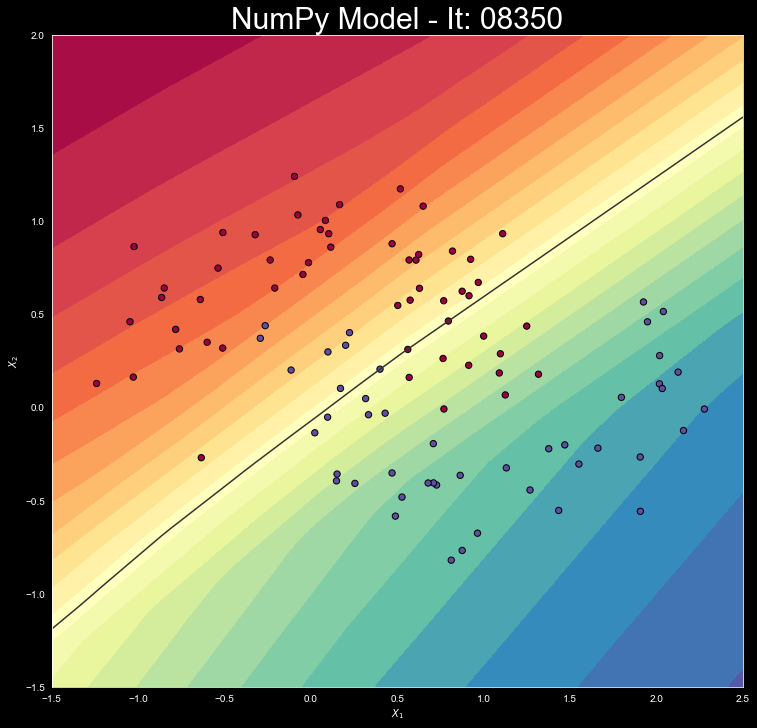

In [26]:
# boundary of the graph
GRID_X_START = -1.5
GRID_X_END = 2.5
GRID_Y_START = -1.0
GRID_Y_END = 2
# output directory (the folder must be created on the drive)
OUTPUT_DIR = "./binary_classification_vizualizations/"

grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2, -1).T
XX, YY = grid

def callback_numpy_plot(index, params):
    plot_title = "NumPy Model - It: {:05}".format(index)
    file_name = "numpy_model_{:05}.png".format(index//50)
    file_path = os.path.join(OUTPUT_DIR, file_name)
    prediction_probs, _ = full_forward_propagation(np.transpose(grid_2d), params, NN_ARCHITECTURE)
    prediction_probs = prediction_probs.reshape(prediction_probs.shape[1], 1)
    make_plot(X_test, y_test, plot_title, file_name=file_path, XX=XX, YY=YY, preds=prediction_probs, dark=True)
# Training
params_values = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 100000, 0.001, False, callback_numpy_plot)
prediction_probs_numpy, _ = full_forward_propagation(np.transpose(grid_2d), params_values, NN_ARCHITECTURE)
prediction_probs_numpy = prediction_probs_numpy.reshape(prediction_probs_numpy.shape[1], 1)
make_plot(X_test, y_test, "NumPy Model", file_name=None, XX=XX, YY=YY, preds=prediction_probs_numpy)
